In [1]:
from utils.result import *
%reload_ext autoreload
%autoreload 2

In [2]:
stimuli = ['0-Bea', '0-Bol', '0-Ctl', '0-DatExt', '0-Far', '0-Ger', '0-Iso', '0-Lin', 
           '0-M2', '0-M3', '0-M4', '0-M5', '0-M6', '0-Mal', '0-Myr', '0-Ner', 
           '1-P3', '1-P4', '1-P5', '1-P9', '1-P9_Hund', '1-P9_Ten', '1-P9_TenThous']

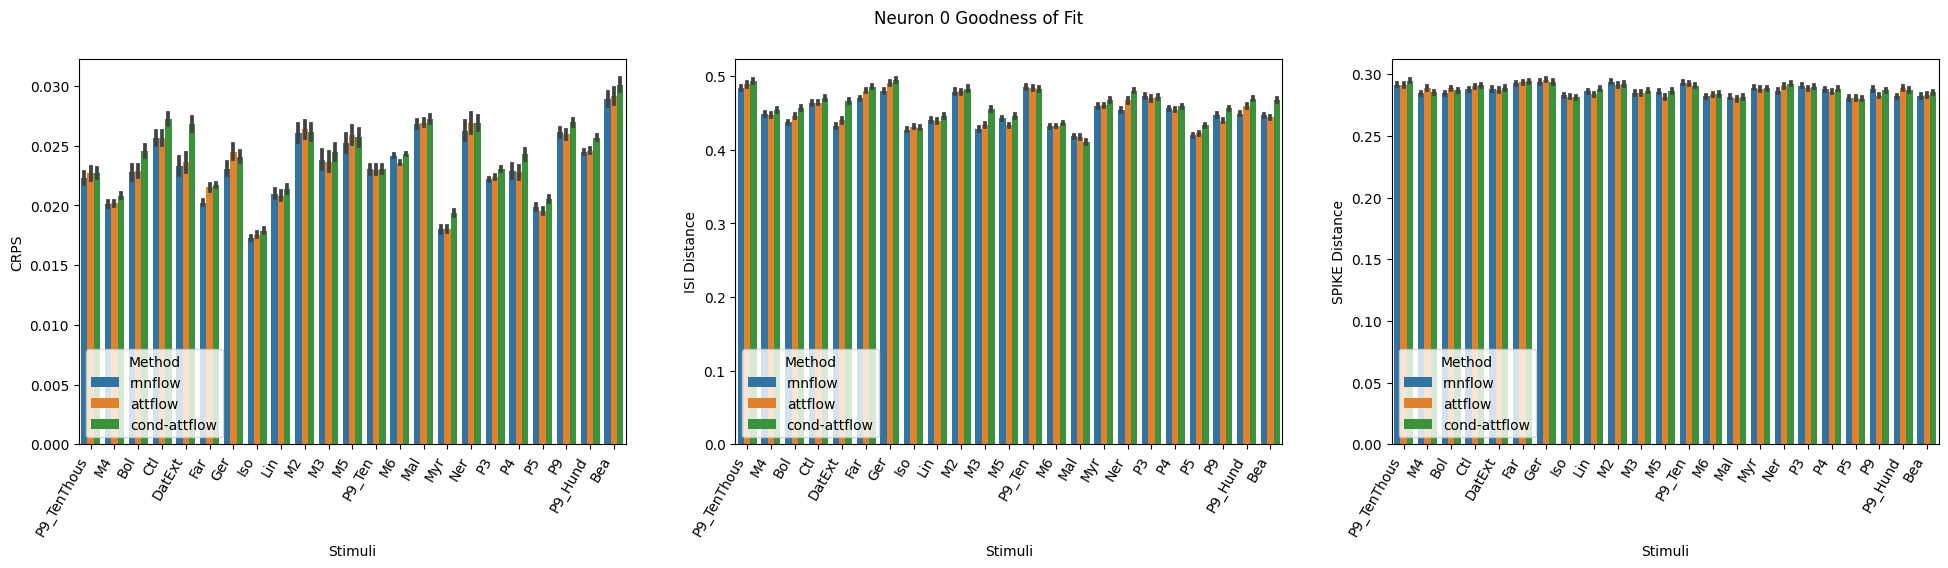

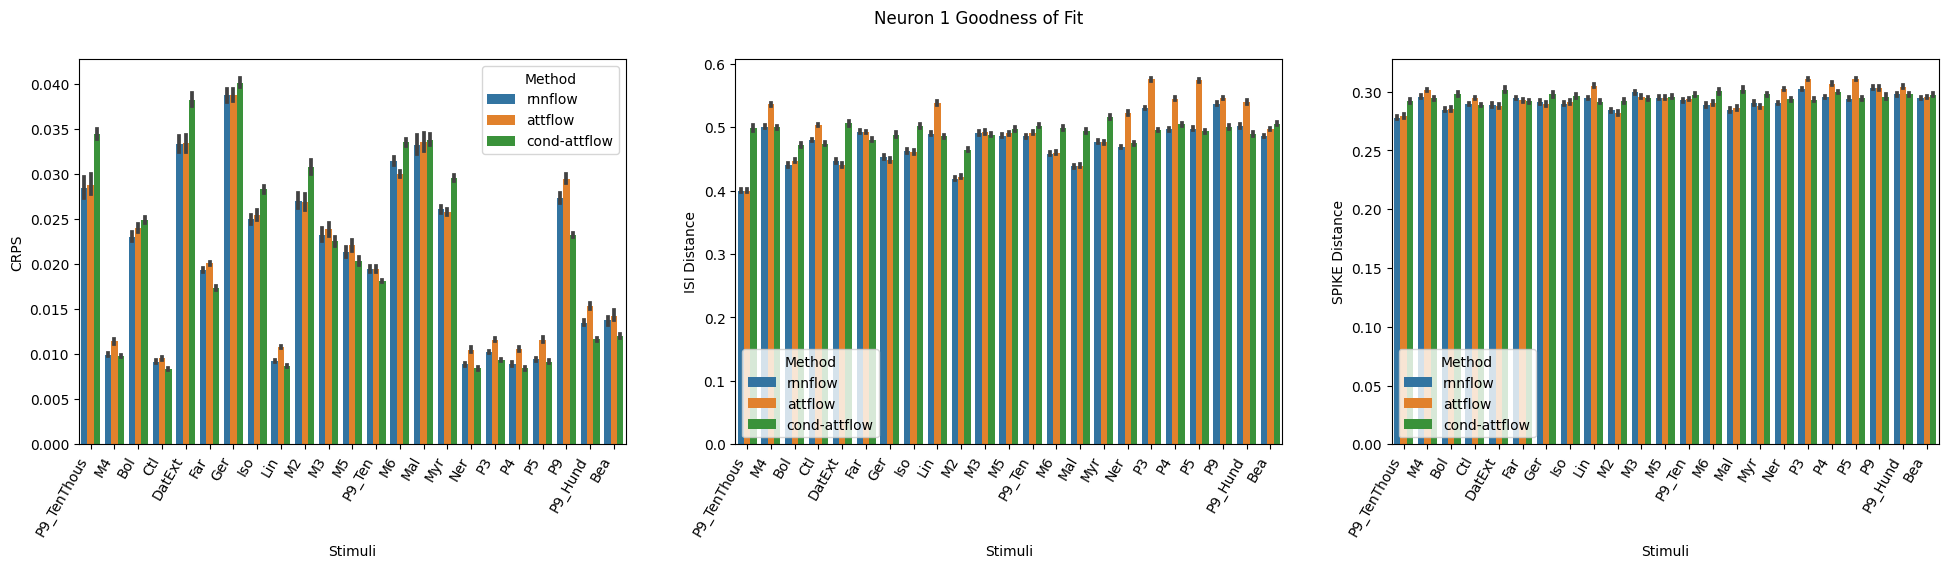

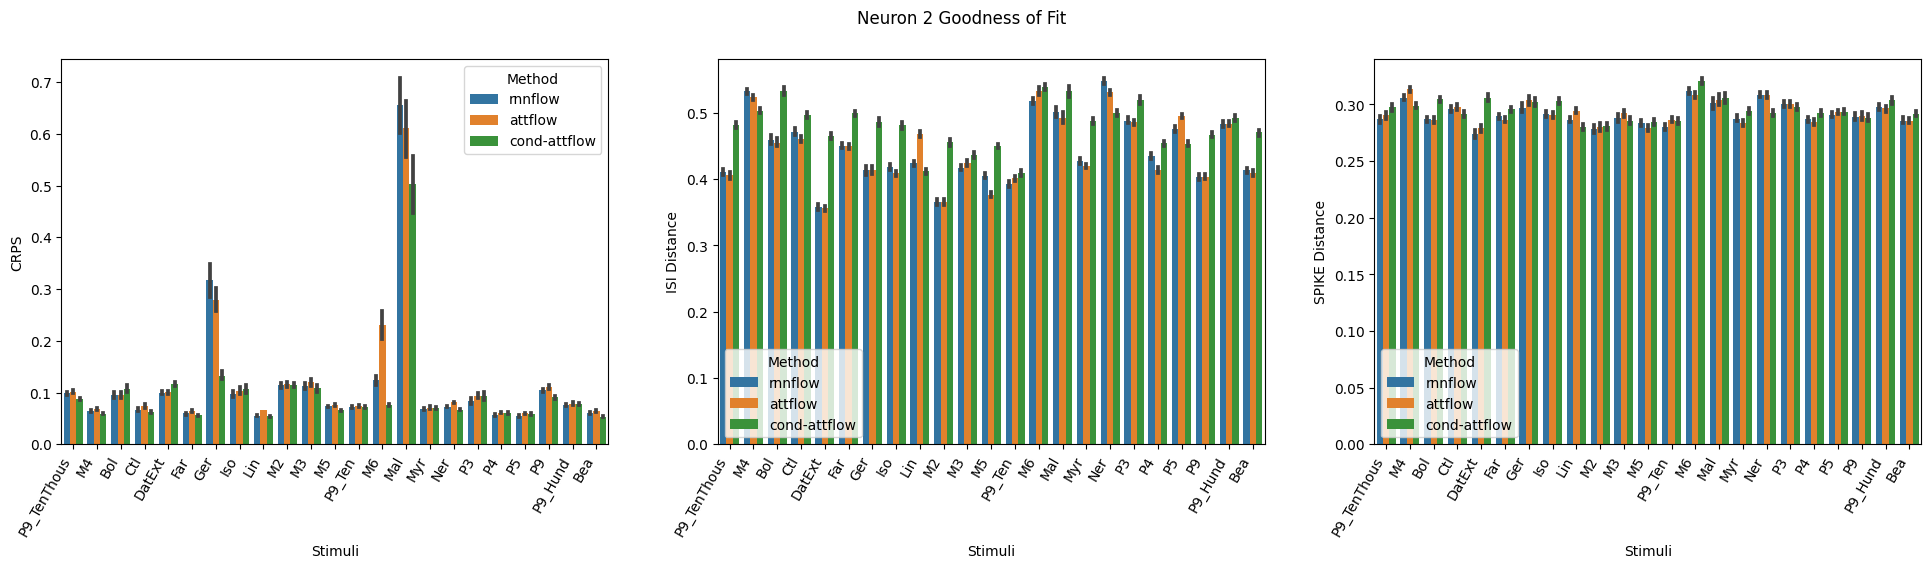

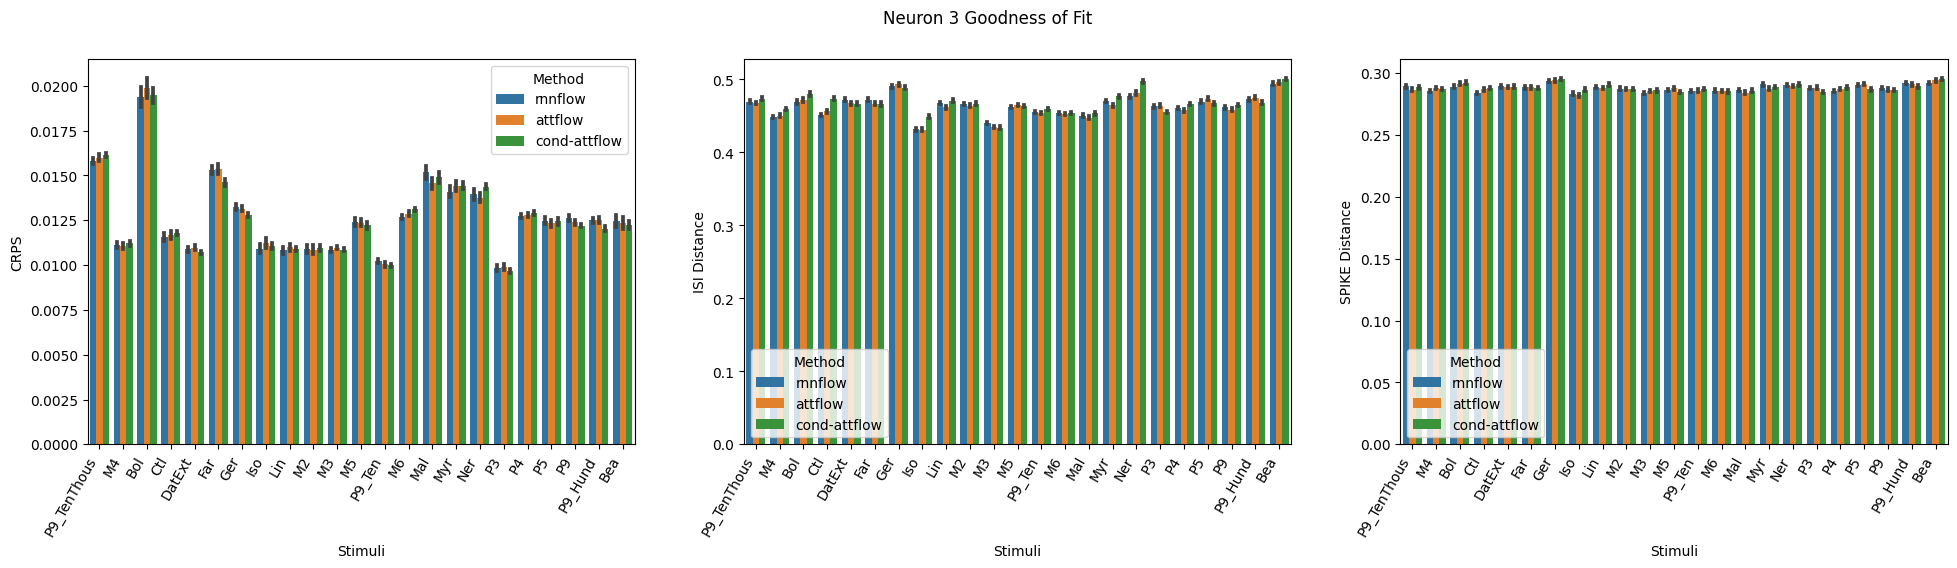

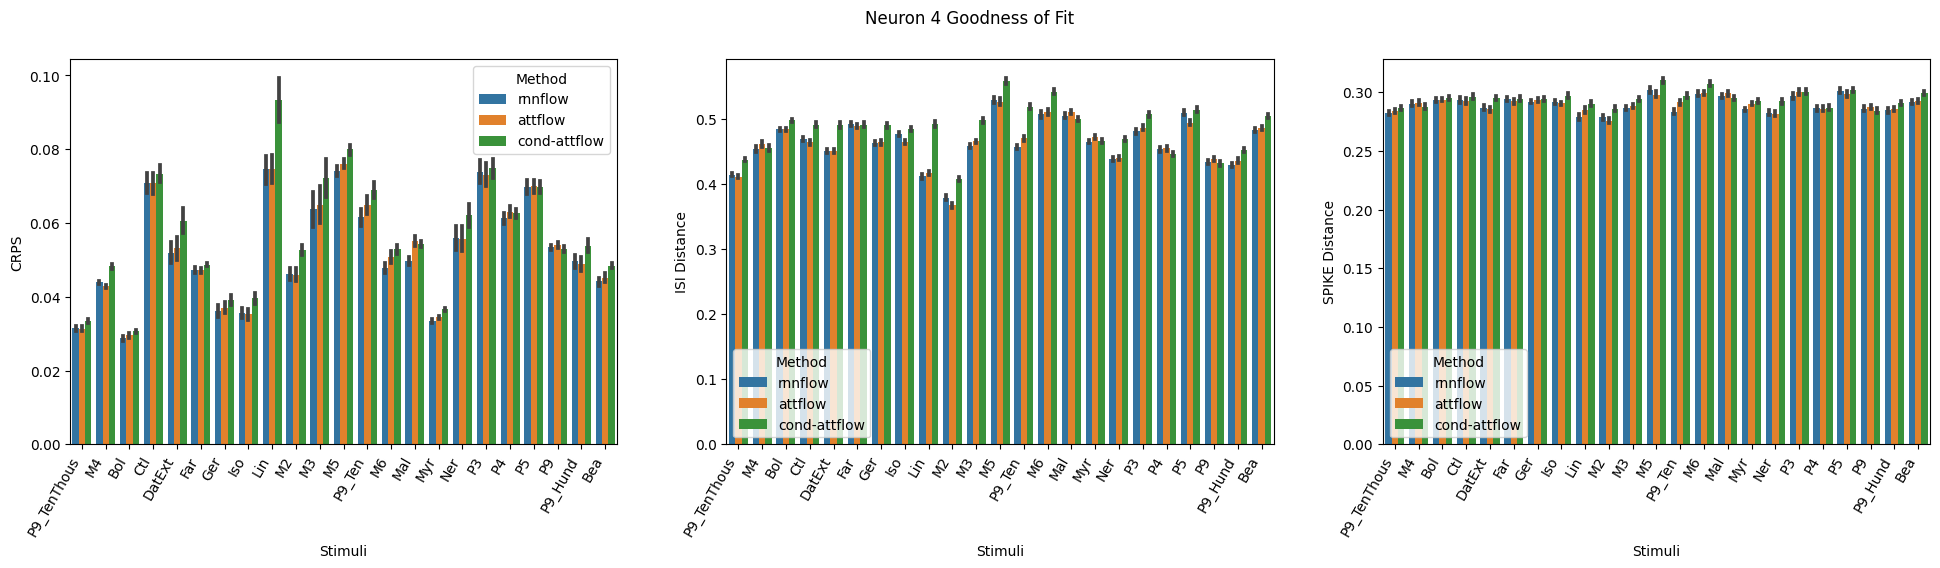

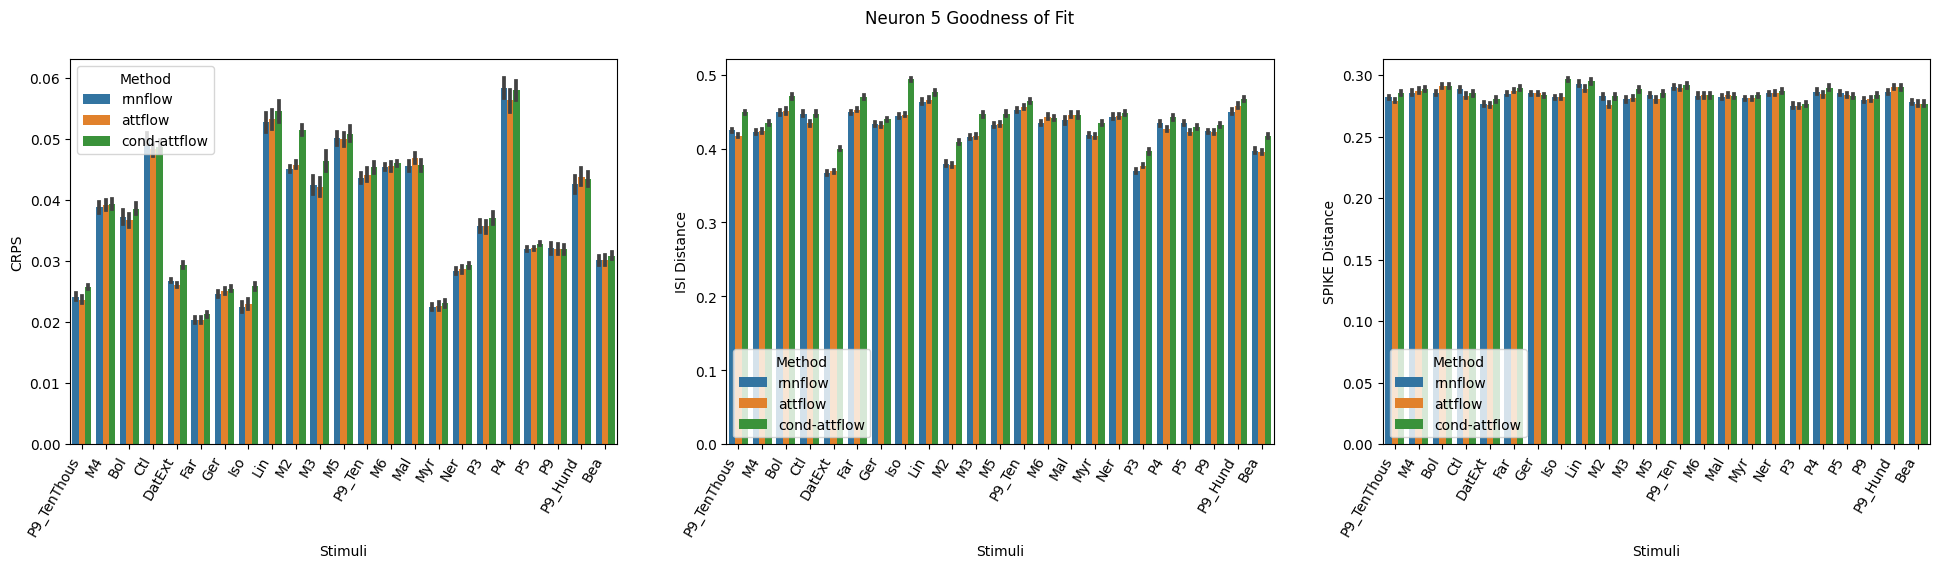

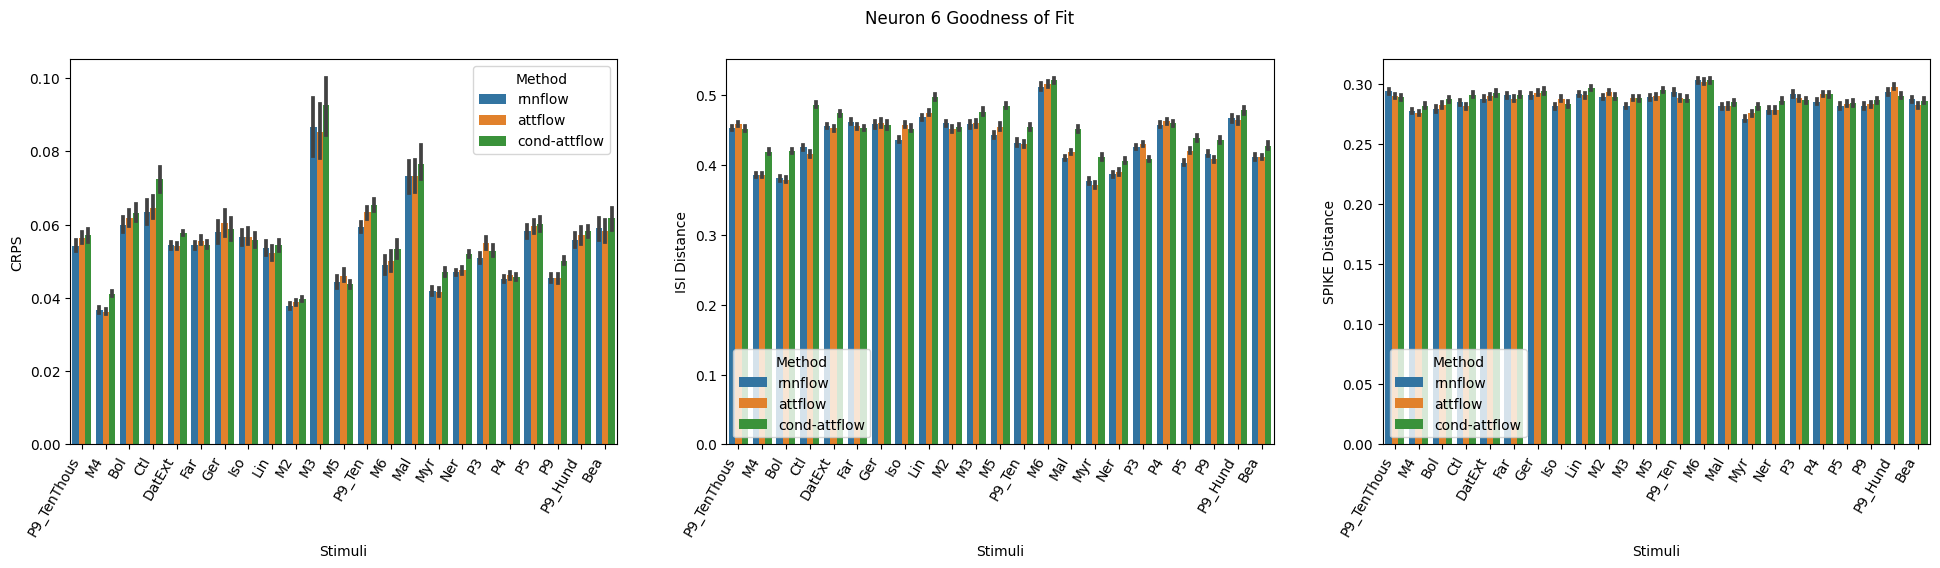

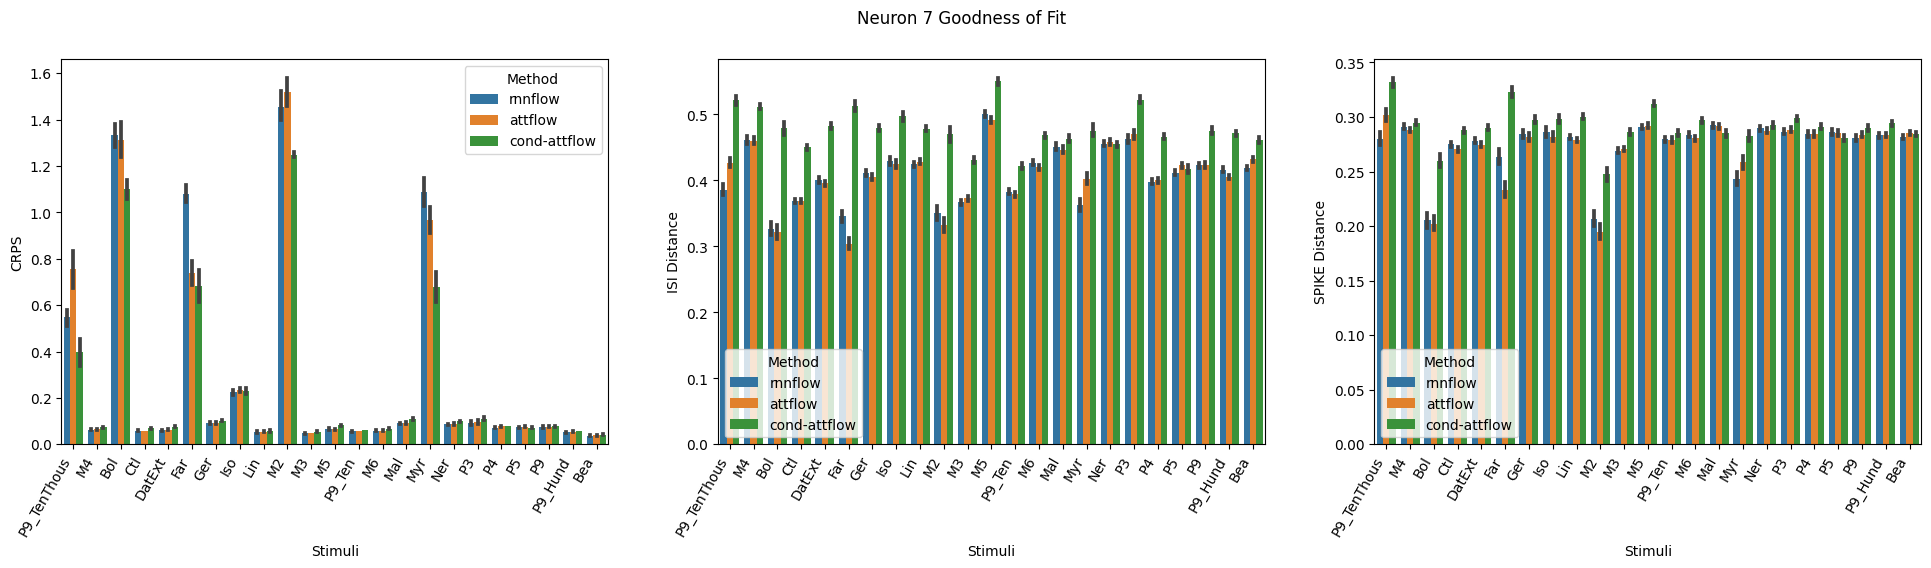

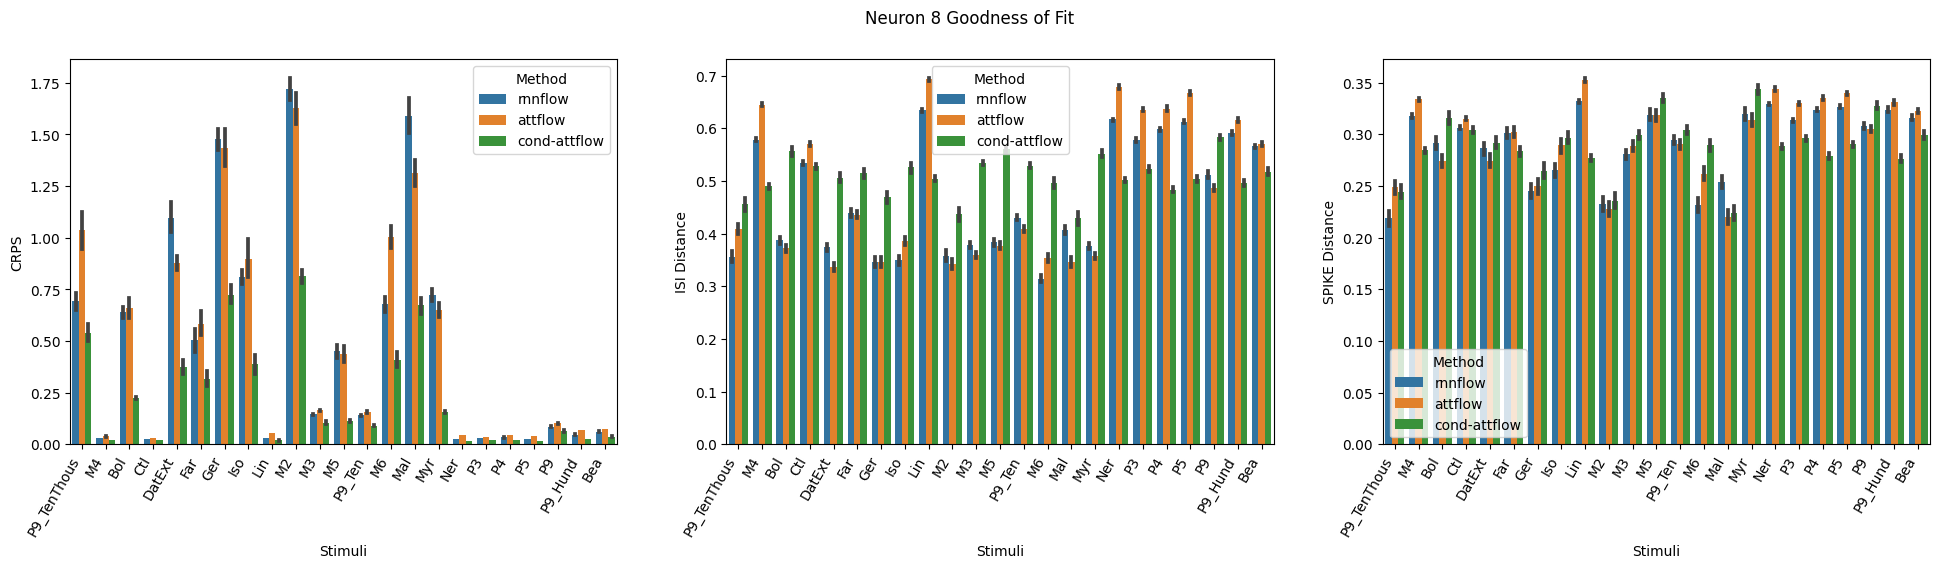

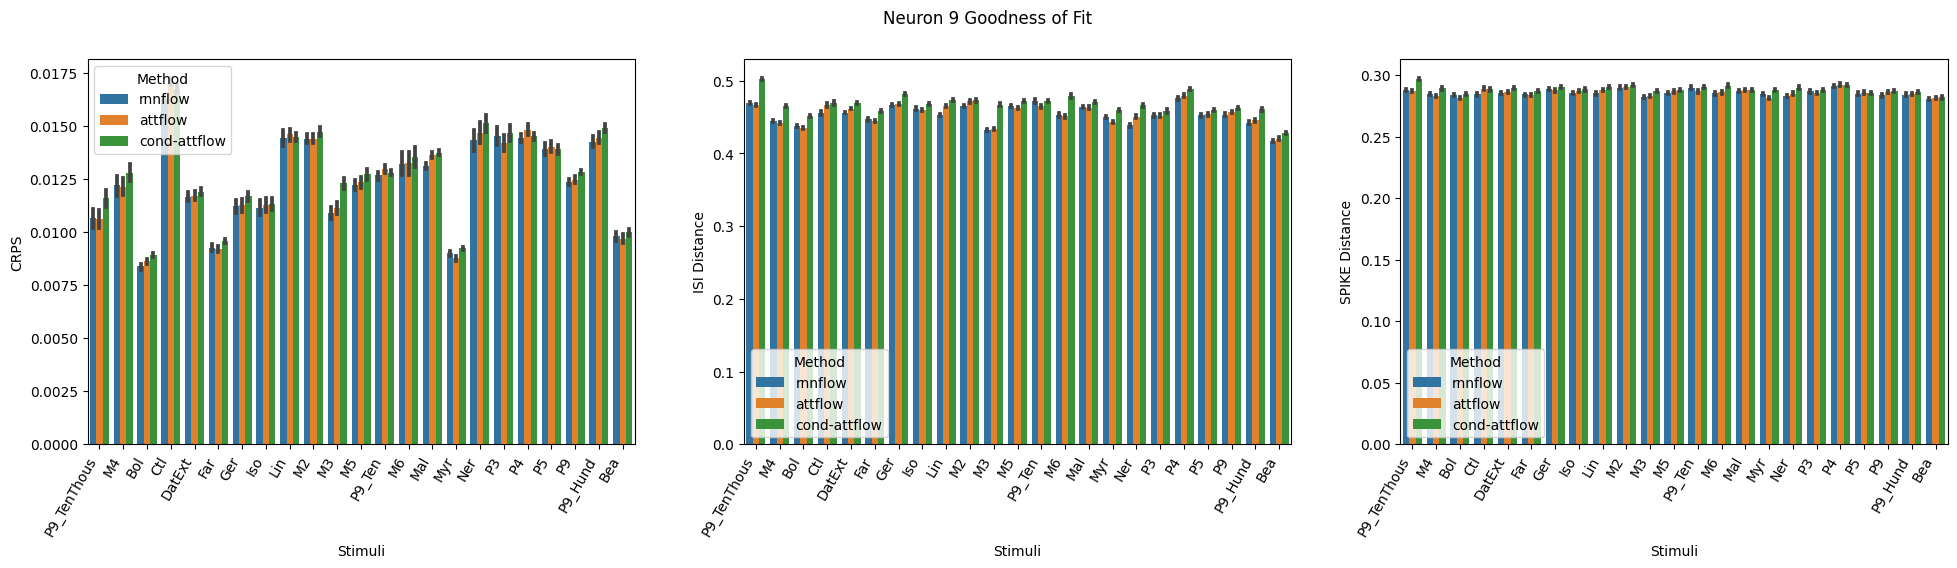

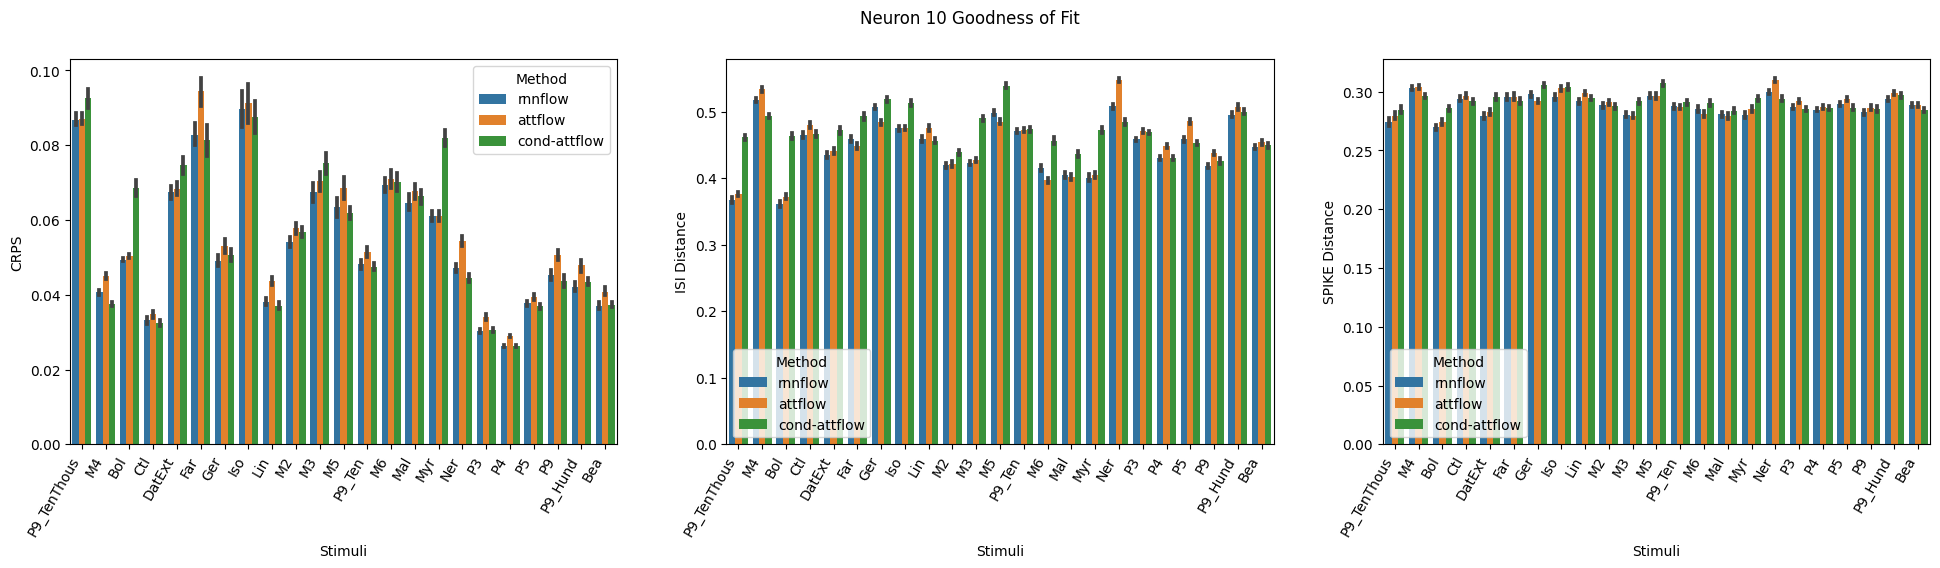

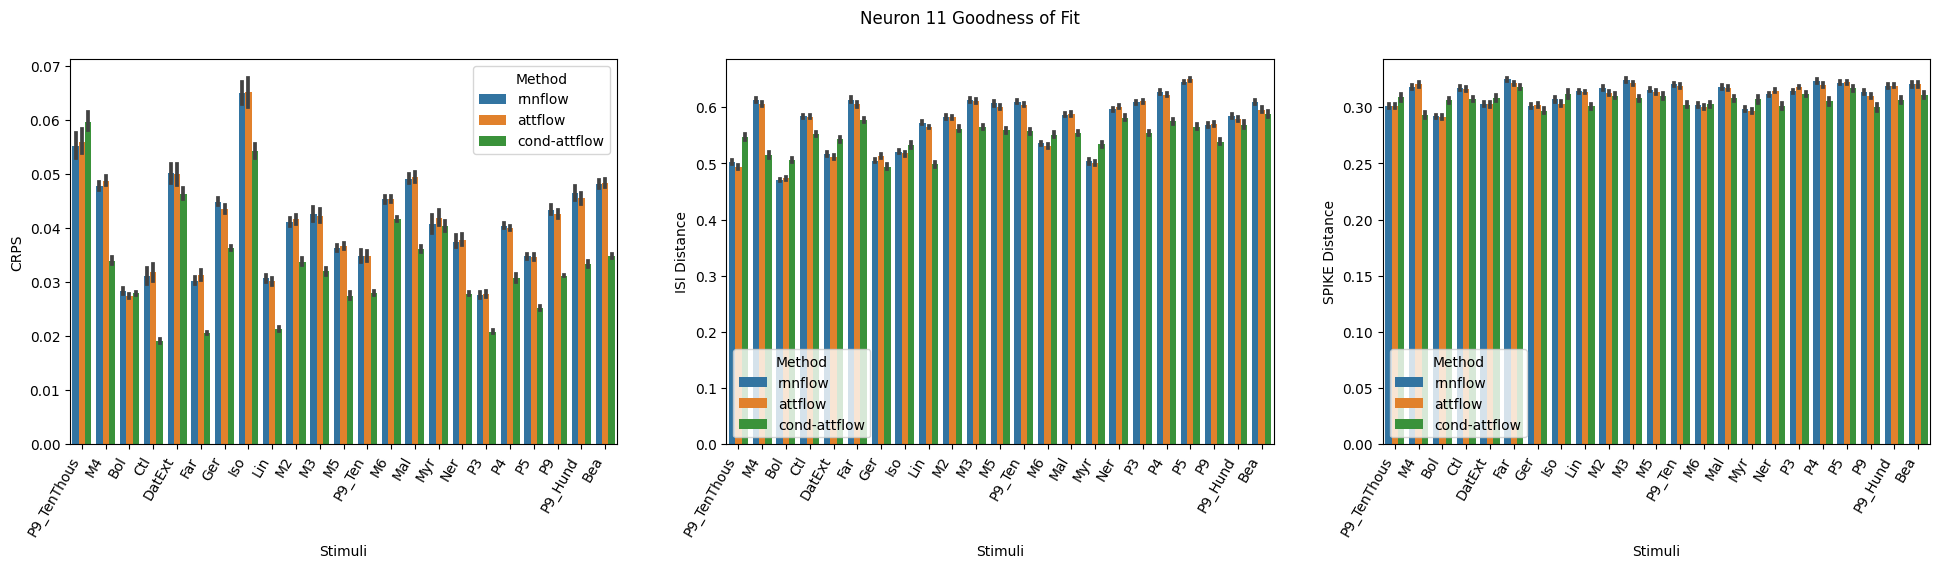

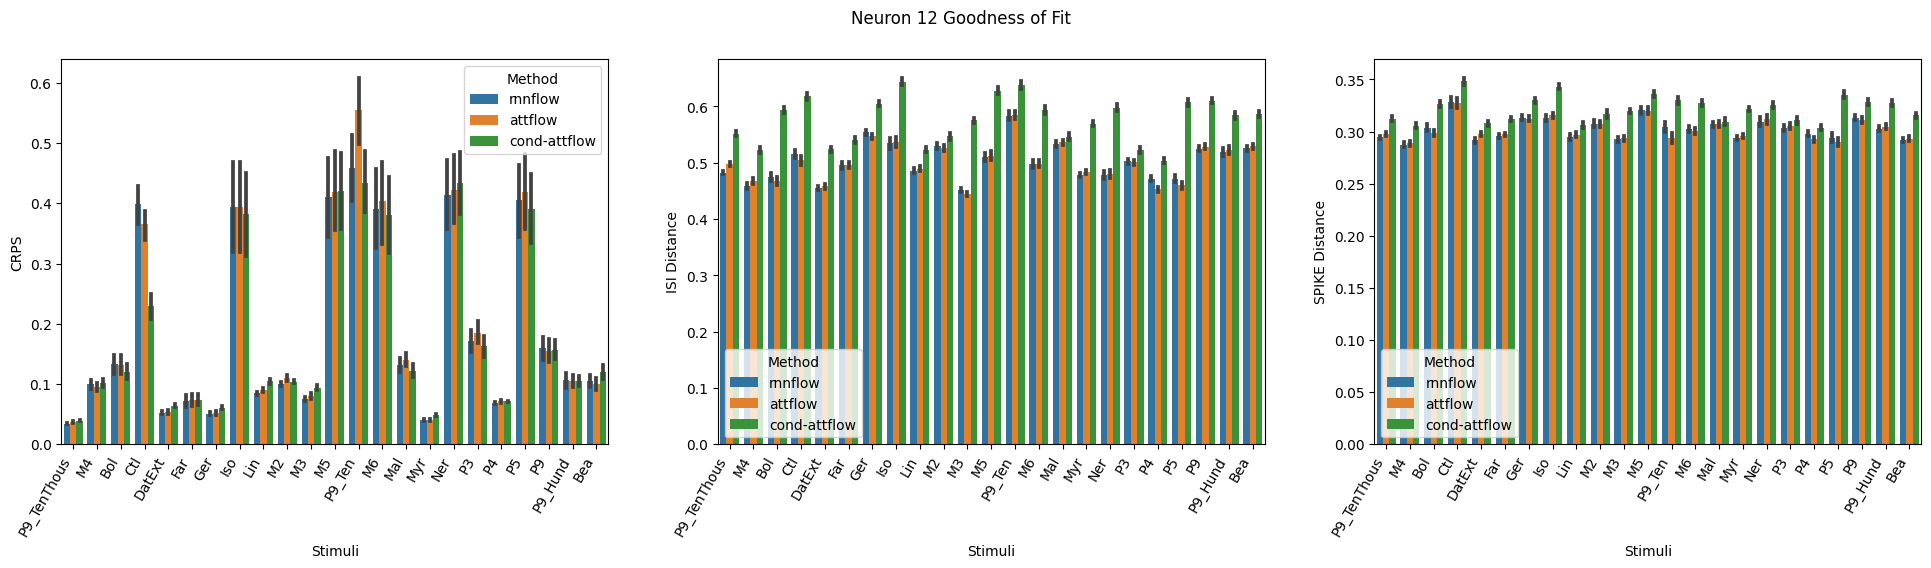

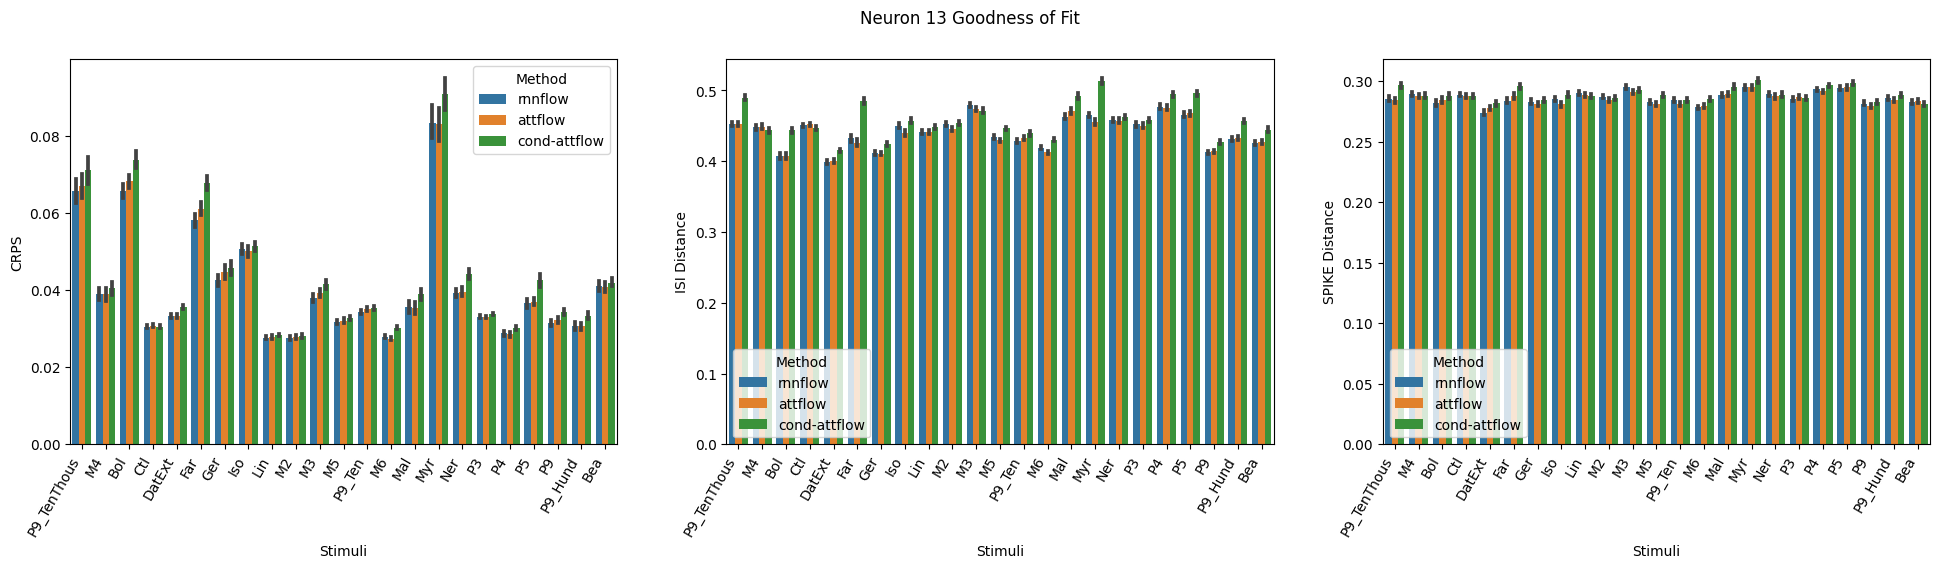

In [3]:
for target in range(0,14):
    rnn_crps_stack, rnn_isi_stack, rnn_spike_stack = analyze_result("config/rnnflow/rnnflow-{}.yaml".format(target), 
                                                                         verbose=False, cond=False)
    att_crps_stack, att_isi_stack, att_spike_stack = analyze_result(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), 
                                                                         verbose=False, cond=False)
    attcond_crps_stack, attcond_isi_stack, attcond_spike_stack = analyze_result(yaml_filepath="config/attflow/attflow-{}.yaml".format(target),
                                                                         verbose=False, cond=True)
    plot_result_bar([rnn_crps_stack, att_crps_stack, attcond_crps_stack],
                [rnn_isi_stack, att_isi_stack, attcond_isi_stack],
                [rnn_spike_stack, att_spike_stack, attcond_spike_stack],
                target, method=["rnnflow", "attflow", "cond-attflow"])

In [4]:
for target in range(0,14):
    rnn_crps_stack, rnn_isi_stack, rnn_spike_stack = analyze_result("config/rnnflow/rnnflow-{}.yaml".format(target), 
                                                                         verbose=False, cond=False)
    att_crps_stack, att_isi_stack, att_spike_stack = analyze_result(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), 
                                                                       verbose=False, cond=False)
    spa_crps_stack, spa_isi_stack, spa_spike_stack = analyze_result(yaml_filepath="config/sparse-attflow/sparse-attflow-{}.yaml".format(target), 
                                                                       verbose=False, cond=False)
    attcond_crps_stack, attcond_isi_stack, attcond_spike_stack = analyze_result(yaml_filepath="config/attflow/attflow-{}.yaml".format(target), 
                                                                         verbose=False, cond=True)
    spa_attcond_crps_stack, spa_attcond_isi_stack, spa_attcond_spike_stack = analyze_result(yaml_filepath="config/sparse-attflow/sparse-attflow-{}.yaml".format(target), 
                                                                         verbose=False, cond=True)
    plot_result_bar([rnn_crps_stack, att_crps_stack,spa_crps_stack, attcond_crps_stack, spa_attcond_crps_stack],
                [rnn_isi_stack, att_isi_stack,spa_isi_stack, attcond_isi_stack, spa_attcond_isi_stack],
                [rnn_spike_stack, att_spike_stack, spa_spike_stack, attcond_spike_stack, spa_attcond_spike_stack],
                target, method=["rnnflow", "attflow", "spa-attflow", "cond-attflow", "cond-spa-attflow"])